# Определение возраста покупателей

Описание проекта: Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, и контролировать добросовестность кассиров при продаже алкоголя.
    
Цель исследования: построить модель, которая по фотографии определит приблизительный возраст человека.

Ход исследования:

    Исследовательский анализ данных: загрузка и изучение информации из датасета, просмотр нескольких фото, распределение возрастов людей
    
    Обучение модели: обучение модели в GPU тренажере
    
    Анализ обученной модели: резюмирование полученных результатов
    

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Исследовательский анализ данных

С помощью загрузчика данных из папки извлеку фотографии и целевой признак и напечатаю несколько фотографий.

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Познакомлюсь с датафреймом

In [8]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [9]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


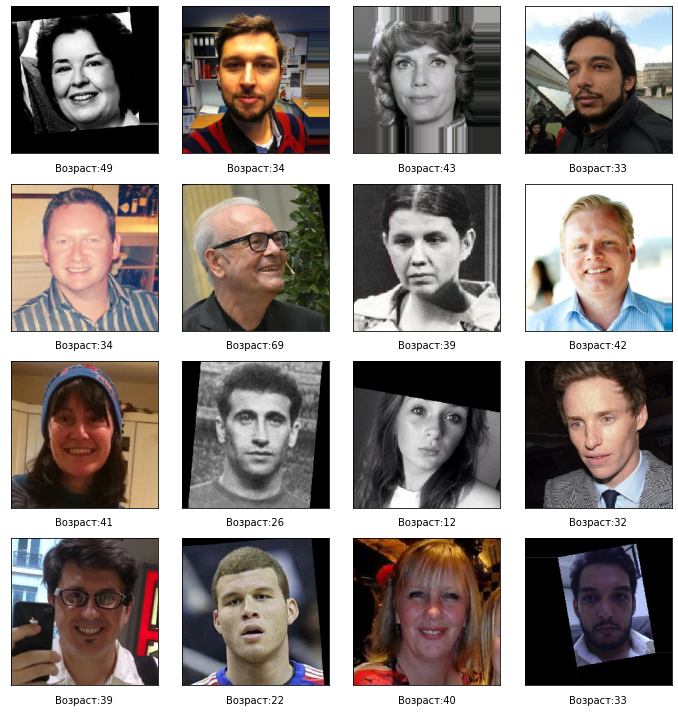

In [7]:
features, target = next(gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.text(0.5, -0.1, 'Возраст:'+str(target[i]), ha='center', va='center',
             transform=ax.transAxes)
    

Рассмотрю также распределение возрастов людей

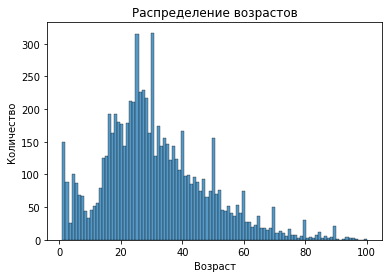

In [10]:
sns.histplot(data=labels,x='real_age',bins=100)
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

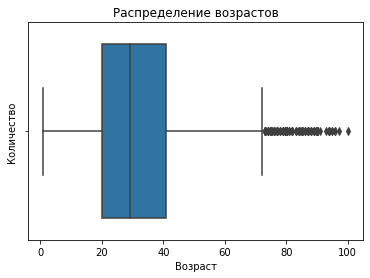

In [12]:
sns.boxplot(data=labels,x='real_age')
plt.title('Распределение возрастов')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

Можно заметить, что в датасете преобладают молодые люди от 16 до 30 лет, среднее количество детей от 0 до 12 лет, а также мало людей старше 60.

В датасете находится 7591 строка, больше всего в нем людей от 20 до 40 лет, а вот людей старше 70 не так много. Также замечу, что некоторые изображения в датасете размыты, или повернуты на небольшой угол.

## Обучение модели

Для обучения модели воспользуюсь архитектурой ResNet50, поскольку она имеет хорошую производительность и справляется с проблемой затухающего градиента

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D,AvgPool2D,Flatten,GlobalAveragePooling2D,BatchNormalization,Dropout
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen=ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255,
        horizontal_flip=True
    )
    train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='training',
    seed=12345
    )
    return train_gen_flow


def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen=ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255
    )
    test_gen_flow = test_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=path + 'final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=16,
    class_mode='raw',
    subset='validation',
    seed=12345
    )
    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
    )
    
    backbone.trainable = True

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dense(1, activation='relu') 
    ])
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5, steps_per_epoch=None, validation_steps=None): 
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    
    return model
```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
356/356 - 62s - loss: 203.4326 - mae: 10.4373 - val_loss: 640.3408 - val_mae: 20.2758
Epoch 2/5
356/356 - 50s - loss: 69.8662 - mae: 6.3573 - val_loss: 123.7196 - val_mae: 8.4323
Epoch 3/5
356/356 - 66s - loss: 37.7047 - mae: 4.7239 - val_loss: 71.6575 - val_mae: 6.3140
Epoch 4/5
356/356 - 54s - loss: 23.9475 - mae: 3.7771 - val_loss: 69.8862 - val_mae: 6.3180
Epoch 5/5
356/356 - 51s - loss: 16.4140 - mae: 3.1356 - val_loss: 79.9712 - val_mae: 6.9044
```

## Анализ обученной модели

Благодаря архитектуре ResNet50 на датасете была достигнута метрика mae=6.9044, что соответствует техническому заданию. В качестве функции активации была использована RelU, а оптимизатором являлся adam с learning_rate=0.0001